##### LightGBM, which has good performance in terms of accuracy and predictive power, also handling categorical features well.

In [7]:
import sklearn as skl
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sqlalchemy import create_engine
from config import CONNSTRING
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [8]:
# Create a database engine
engine = create_engine(CONNSTRING)

# Define your SQL query
query = "SELECT * FROM PatientData"

# Use pandas to read the data into a DataFrame
liver_data_df = pd.read_sql(query, engine)
liver_data_df.head()

,age,gender,bmi,alcoholconsumption,smoking,geneticrisk,physicalactivity,diabetes,hypertension,liverfunctiontest,diagnosis
0,58,0,35.857584,17.272828,0,1,0.658940,0,0,42.734240,1
1,71,1,30.732470,2.201266,0,1,1.670557,1,0,67.309822,1
2,48,0,19.971407,18.500944,0,0,9.928308,0,0,63.738956,0
3,34,1,16.615417,12.632870,0,0,5.630129,0,0,64.555873,1
4,62,1,16.065830,1.087815,0,1,3.566218,1,0,77.868689,1


In [9]:
# Split our data into our features and target arrays
X = liver_data_df.copy()
X.drop('diagnosis', axis=1, inplace=True)
y = liver_data_df['diagnosis']

In [10]:
# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [11]:
# Create a StandardScaler instances
X_scaler = skl.preprocessing.StandardScaler()

# Fit the StandardScaler
X_scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [12]:
# Create LightGBM datasets
train_data = lgb.Dataset(X_train_scaled, label=y_train)
test_data = lgb.Dataset(X_test_scaled, label=y_test, reference=train_data)

In [13]:
# Set up the parameters for LightGBM
params = {
    'objective': 'binary',
    'metric': 'binary_error',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

In [14]:
# Train the LightGBM model
model_gbm = lgb.train(params, train_data, num_boost_round=1000, valid_sets=[test_data], callbacks=[lgb.early_stopping(stopping_rounds=50)])

[LightGBM] [Info] Number of positive: 704, number of negative: 571
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000441 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1098
[LightGBM] [Info] Number of data points in the train set: 1275, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552157 -> initscore=0.209389
[LightGBM] [Info] Start training from score 0.209389
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[36]	valid_0's binary_error: 0.0894118


In [15]:
# Predict the test set
y_pred = model_gbm.predict(X_test_scaled, num_iteration=model_gbm.best_iteration)
y_pred_binary = [1 if pred > 0.5 else 0 for pred in y_pred]

In [16]:
# Evaluate the model
accuracy_gbm = accuracy_score(y_test, y_pred_binary)
conf_matrix_gbm = confusion_matrix(y_test, y_pred_binary)
class_report_gbm = classification_report(y_test, y_pred_binary)

print("Accuracy:", accuracy_gbm)
print("Confusion Matrix:\n", conf_matrix_gbm)
print("Classification Report:\n", class_report_gbm)

Accuracy: 0.9105882352941177
Confusion Matrix:
 [[174  19]
 [ 19 213]]
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.90      0.90       193
           1       0.92      0.92      0.92       232

    accuracy                           0.91       425
   macro avg       0.91      0.91      0.91       425
weighted avg       0.91      0.91      0.91       425



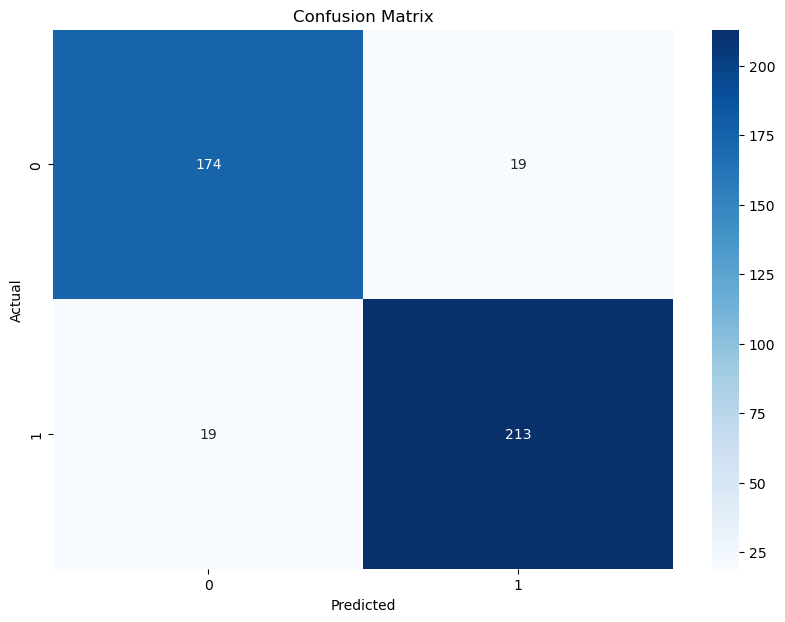

In [17]:
# Confusion Matrix visualization
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_gbm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [18]:
# Save the model
joblib.dump(model_gbm, 'model_gbm.joblib')

# Save the scaler
joblib.dump(X_scaler, 'scaler_gbm.joblib')

['scaler_gbm.joblib']